In [1]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [2]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
market_kwargs = dict(start_volumes=5, base_price=10, start_gains=250, deprecation_steps=1)
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),
]
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
]
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         batch_size=1)
critic = CentralizedCritic2
trainer = TrainerSAC(env, q_critic=critic, batch_size=512)

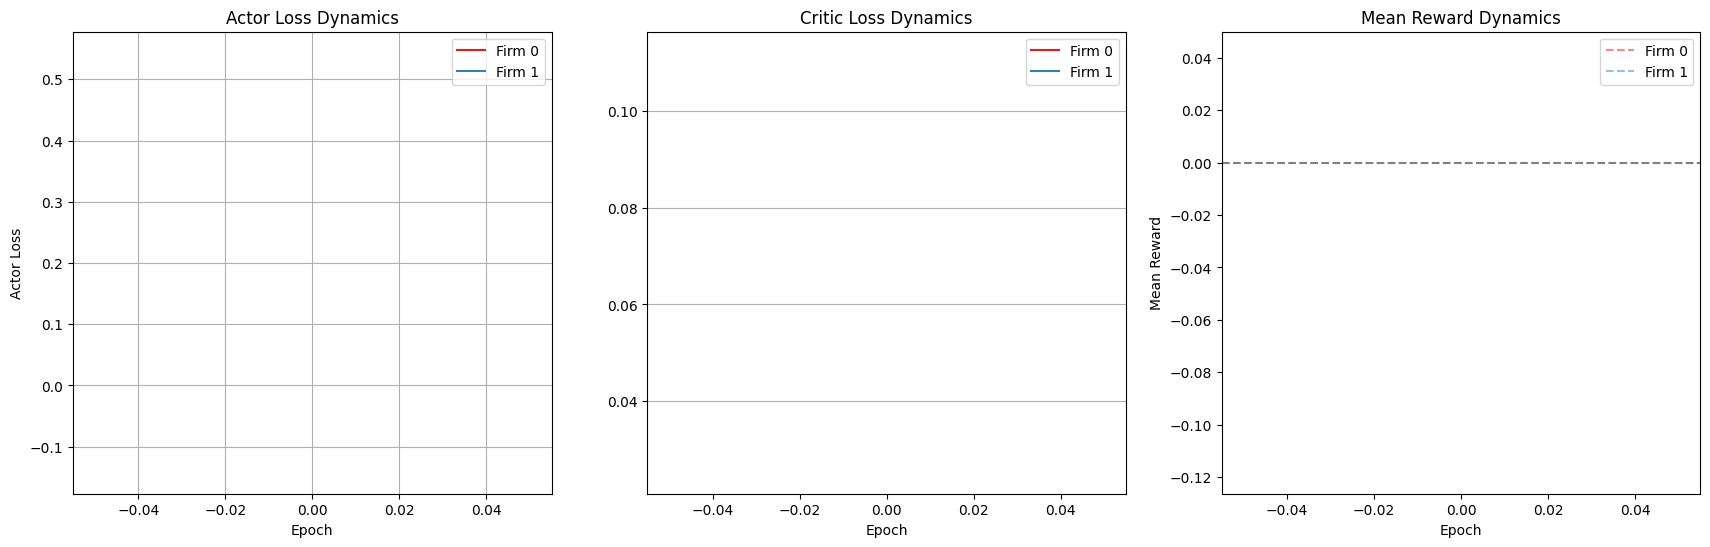

  0%|▏                                                                                 | 2/1000 [00:03<26:41,  1.60s/it, LR=0.00029700749999999996]

KeyboardInterrupt



In [3]:
env.change_batch_size(512)
env.reset()
trainer.train(1000, episode_length=30)

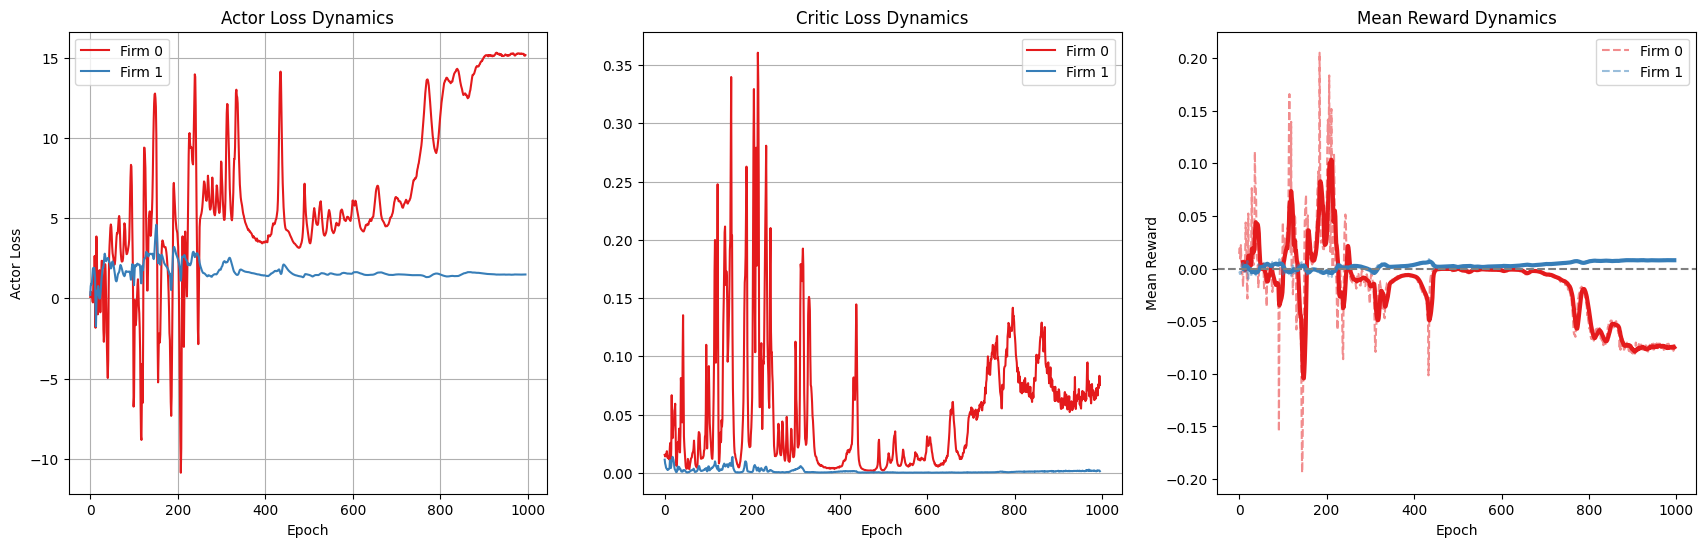

100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [46:22<00:00,  2.78s/it, LR=1.99619057364959e-06]


In [33]:
env.change_batch_size(512)
env.reset()
trainer.train(1000, episode_length=30)

In [55]:
env = trainer.environment
env.reset()
env.change_batch_size(1)

In [56]:
n_periods = 30
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
# env.firms

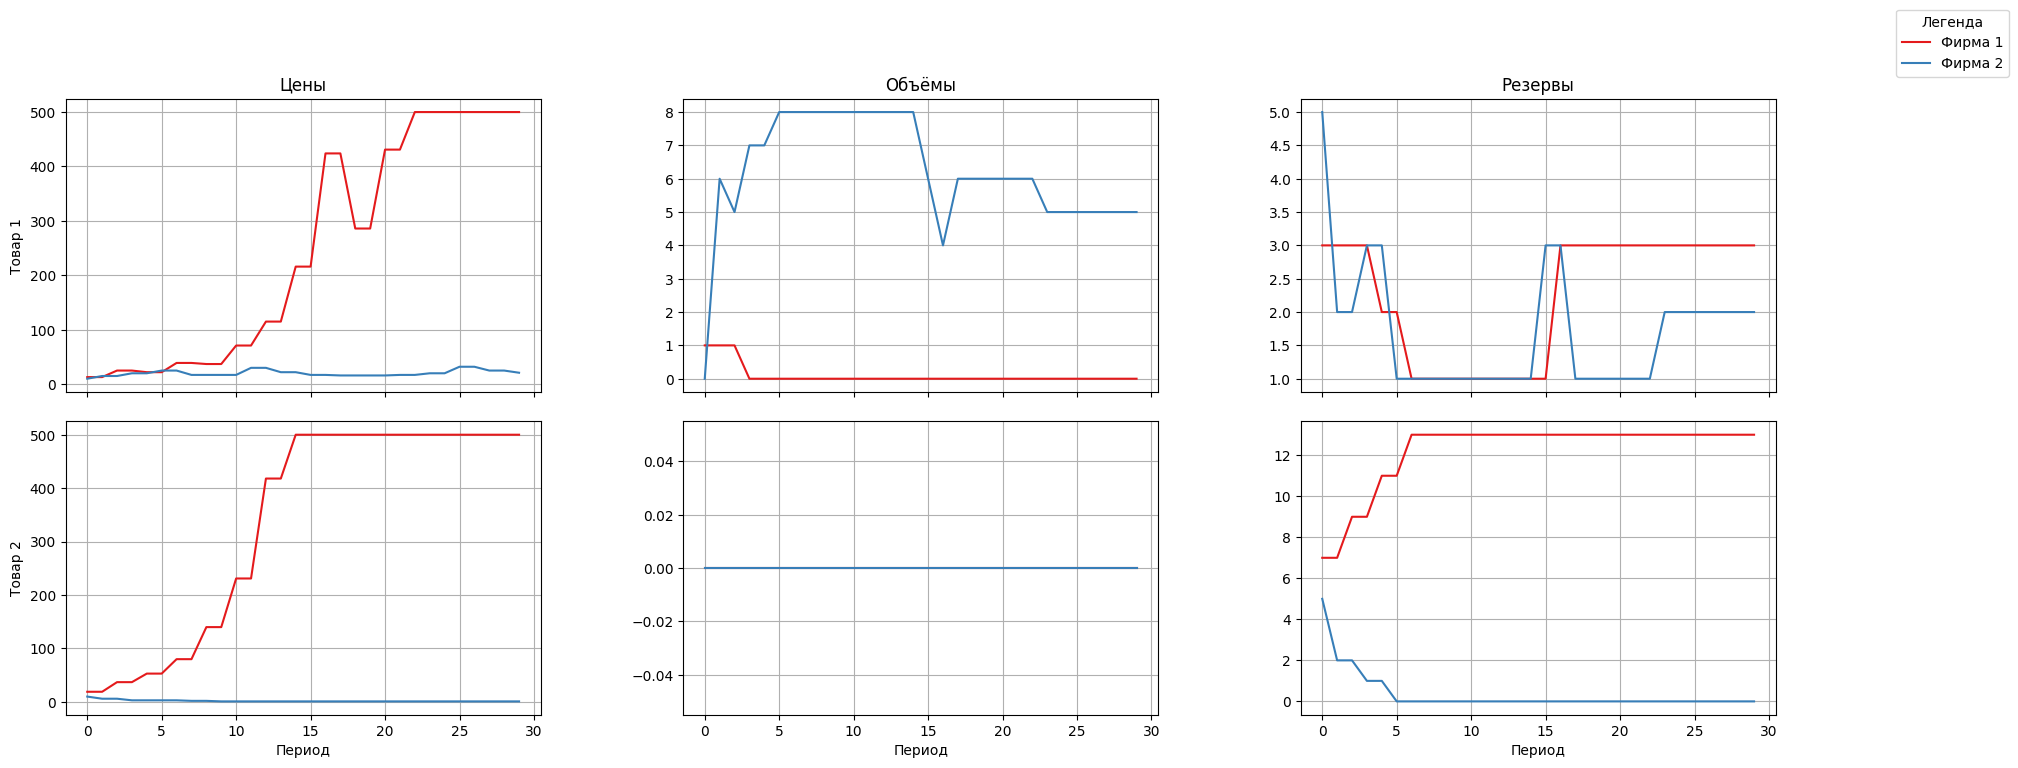

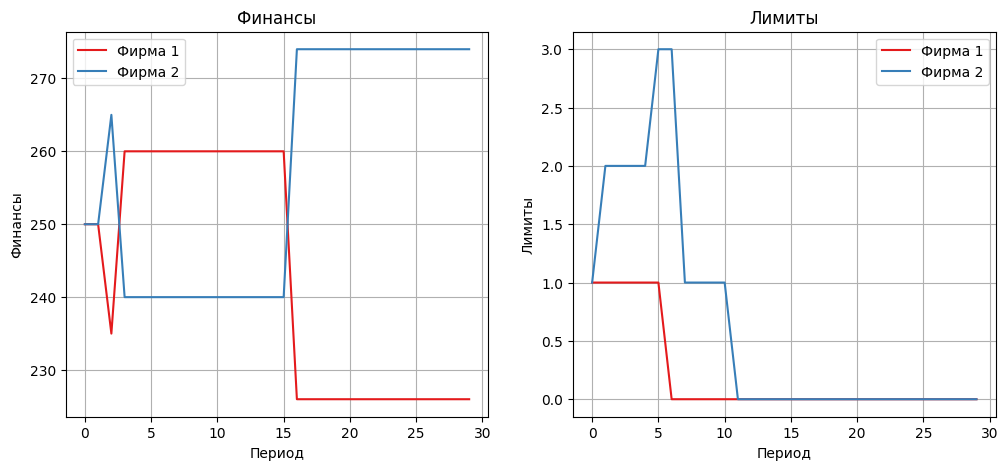

In [57]:
from utils.plotting import plot_actions, plot_environment

plot_environment(env.state_history)

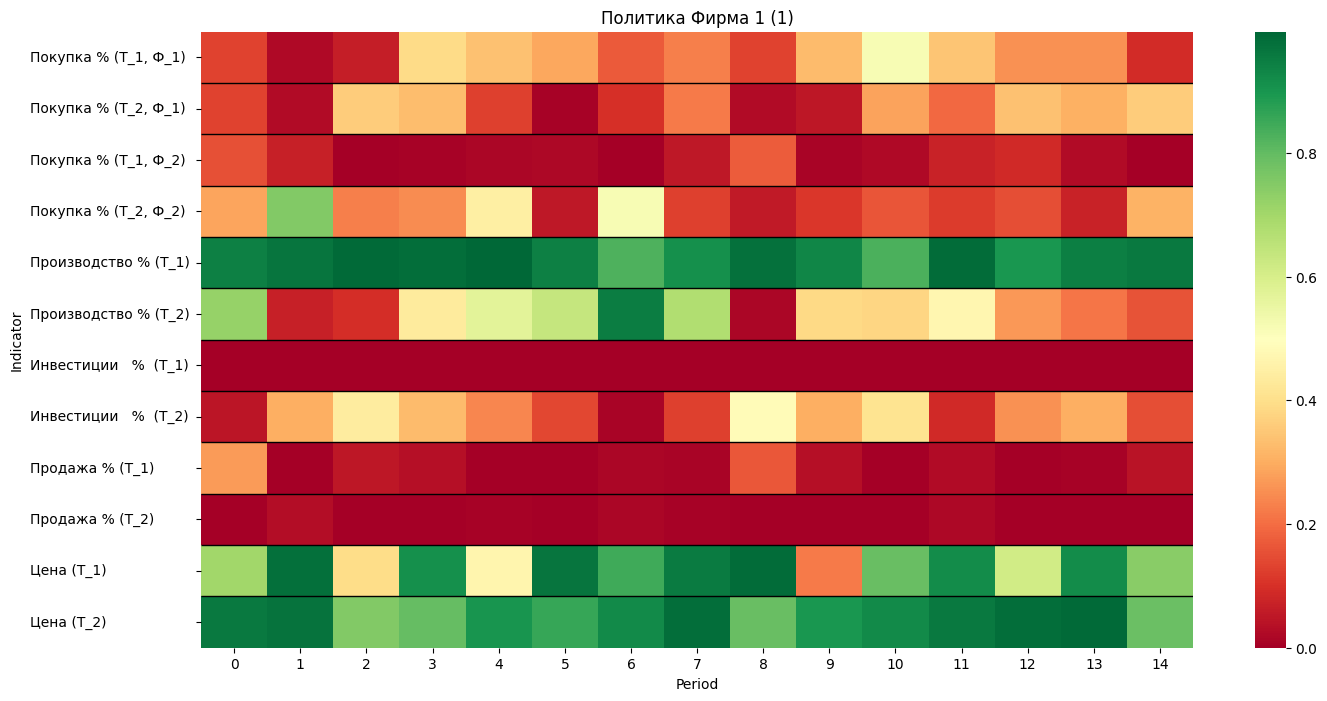

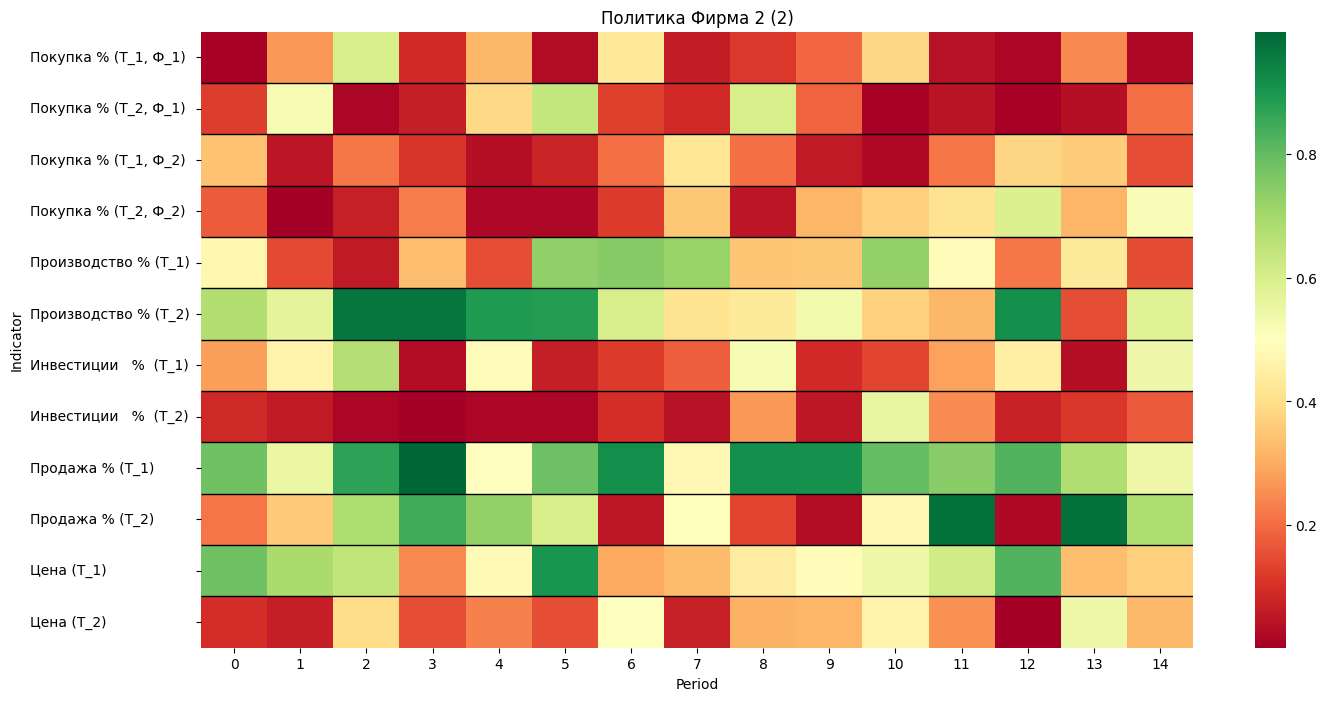

In [58]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')